In [1]:
import glob
def read_txt(list):
    for f in read_files:
        with open(f, "rb") as infile:
            list.append(str(infile.read(), 'utf-8'))

def get_txt_score(list):
    for f in read_files:
        base= os.path.basename(f)
        # we get the last number in each file, which is score of each rating
        # note that 0 denotes the score 10
        list.append(os.path.splitext(base)[0][-1])
            
class Data:
    def __init__(self, text, target):
        self.text = text
        self.target = target

In [2]:
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/train/neg/*.txt")
neg_train = []
read_txt(neg_train)
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/train/pos/*.txt")
pos_train = []
read_txt(pos_train)
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/test/neg/*.txt")
neg_test = []
read_txt(neg_test)
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/test/pos/*.txt")
pos_test = []
read_txt(pos_test)

In [3]:
import numpy as np
def merge_data(neg,pos):
    return Data(neg + pos,np.concatenate((np.zeros(len(neg)), np.ones(len(pos)))))

In [4]:
train_valid_split = 2500
valid = merge_data(neg_train[:train_valid_split],pos_train[:train_valid_split])
train = merge_data(neg_train[train_valid_split:],pos_train[train_valid_split:])
test = merge_data(neg_test,pos_test)

In [38]:
import numpy as np
import torch
from torch.utils.data import Dataset

class GroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

In [39]:
def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [40]:
def tune_batch_size(data_ind, data_target, BATCH_SIZE = 50, shuffle = True):
    data = GroupDataset(data_ind, data_target)
    loader = torch.utils.data.DataLoader(dataset=data, batch_size=BATCH_SIZE,
                                            collate_fn=collate_func, shuffle = shuffle)
    return loader

In [45]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        # self.drop =  nn.Dropout(0.5) 
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        # out = self.drop(out)
        # return logits
        out = self.linear(out.float())
        return out

In [ ]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [ ]:
def build_vocab(all_tokens, max_vocab_size = 25000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [ ]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [49]:
import copy
import pickle as pkl
from collections import Counter

def try_sen_len():
    train_data_tokens = pkl.load(open("train_data_1_gram_w_Cap.p", "rb"))
    all_train_tokens = pkl.load(open("all_train_1_gram_w_Cap.p", "rb"))
    val_data_tokens = pkl.load(open("val_data_1_gram_w_Cap.p", "rb")) 
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    train_loader = tune_batch_size(train_data_indices, train.target, BATCH_SIZE = 50)
    val_loader = tune_batch_size(val_data_indices, valid.target, BATCH_SIZE = 50)
    model = BagOfWords(len(id2token), 500)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)
    _list = []
    for epoch in range(20):
        scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            if i > 0 and i % 200 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, 20, i+1, len(train_loader), val_acc))
        print(epoch)
        _list.append( test_model(val_loader, model))
    return _list

In [50]:
set_len = {}
# we further explore whether sentence length has impact on model performance
for max_len in [100,200,500,1000]:
    MAX_SENTENCE_LENGTH = max_len
    set_len[max_len] = try_sen_len()

Epoch: [1/20], Step: [201/400], Validation Acc: 72.62
0
Epoch: [2/20], Step: [201/400], Validation Acc: 81.4
1
Epoch: [3/20], Step: [201/400], Validation Acc: 83.48
2
Epoch: [4/20], Step: [201/400], Validation Acc: 84.14
3
Epoch: [5/20], Step: [201/400], Validation Acc: 84.46
4
Epoch: [6/20], Step: [201/400], Validation Acc: 84.52
5
Epoch: [7/20], Step: [201/400], Validation Acc: 83.98
6
Epoch: [8/20], Step: [201/400], Validation Acc: 84.18
7
Epoch: [9/20], Step: [201/400], Validation Acc: 83.84
8
Epoch: [10/20], Step: [201/400], Validation Acc: 83.9
9
Epoch: [11/20], Step: [201/400], Validation Acc: 84.04
10
Epoch: [12/20], Step: [201/400], Validation Acc: 83.62
11
Epoch: [13/20], Step: [201/400], Validation Acc: 83.58
12
Epoch: [14/20], Step: [201/400], Validation Acc: 83.44
13
Epoch: [15/20], Step: [201/400], Validation Acc: 83.48
14
Epoch: [16/20], Step: [201/400], Validation Acc: 83.22
15
Epoch: [17/20], Step: [201/400], Validation Acc: 83.24
16
Epoch: [18/20], Step: [201/400], Va

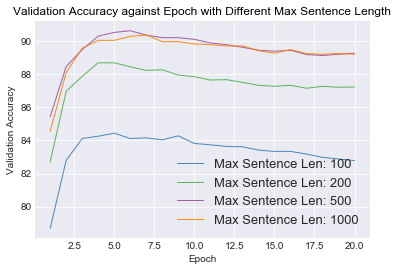

In [53]:
import pandas as pd
df_x = pd.DataFrame({'Epoch': range(1,21)})
df_y = pd.DataFrame(set_len)
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num=0
# now we plot cures based on the data we have 
for column in df_y:
    num+=1
    plt.plot(df_x['Epoch'], df_y[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label= 'Max Sentence Len: ' + str(column))
    plt.legend(loc=4, ncol=1,fontsize =13)
    plt.title("Validation Accuracy against Epoch with Different Max Sentence Length", fontsize=12, fontweight=0, color='black')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")

In [ ]:
MAX_SENTENCE_LENGTH = 500
# calculate validation accuray and test accuray after tuning MAX_SENTENCE_LENGTH
def build_final_model_improve():
    train_data_tokens = pkl.load(open("train_data_1_gram_w_Cap.p", "rb"))
    all_train_tokens = pkl.load(open("all_train_1_gram_w_Cap.p", "rb"))
    val_data_tokens = pkl.load(open("val_data_1_gram_w_Cap.p", "rb"))
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    train_loader = tune_batch_size(train_data_indices, train.target, BATCH_SIZE = 50)
    val_loader = tune_batch_size(val_data_indices, valid.target, BATCH_SIZE = 50)
    model = BagOfWords(len(id2token), 500)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)
    # initialize with 0 for comparison 
    _list = [0]
    for epoch in range(20):
        scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
        # early stopping
        if (_list[-1] <= test_model(val_loader, model) ):
            model_copy = copy.deepcopy(model)
        else:
           return model_copy
        _list.append( test_model(val_loader, model))

final_model = build_final_model_improve()
val_data_tokens = pkl.load(open("val_data_1_gram_w_cap.p", "rb"))
test_data_tokens = pkl.load(open("test_data_1_gram_w_Cap.p", "rb"))
all_train_tokens = pkl.load(open("all_train_1_gram_w_Cap.p", "rb"))
token2id, id2token = build_vocab(all_train_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
val_loader = tune_batch_size(val_data_indices, valid.target, BATCH_SIZE = 50)
test_loader = tune_batch_size(test_data_indices, test.target, BATCH_SIZE = 50, shuffle = False)
print ("Val Acc {}".format(test_model(val_loader, final_model)))
print ("Test Acc {}".format(test_model(test_loader, final_model)))

In [68]:
# try different N-gram after MAX_SENTENCE_LENGTH treatment 
MAX_SENTENCE_LENGTH = 500
def build_final_model_improve():
    train_data_tokens = pkl.load(open("train_data_2gram.p", "rb"))
    all_train_tokens = pkl.load(open("all_train_2gram.p", "rb"))
    val_data_tokens = pkl.load(open("val_data_2gram.p", "rb"))
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    train_loader = tune_batch_size(train_data_indices, train.target, BATCH_SIZE = 50)
    val_loader = tune_batch_size(val_data_indices, valid.target, BATCH_SIZE = 50)
    model = BagOfWords(len(id2token), 500)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)
    # initialize with 0 for comparison 
    _list = [0]
    for epoch in range(20):
        scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
        # early stopping
        if (_list[-1] <= test_model(val_loader, model) ):
            model_copy = copy.deepcopy(model)
        else:
           return model_copy
        print(test_model(val_loader, model))
        _list.append( test_model(val_loader, model))

In [69]:
final_model = build_final_model_improve()

82.12
85.72
87.4
87.7
87.7
87.94
88.06


In [70]:
val_data_tokens = pkl.load(open("val_data_2gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_2gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_2gram.p", "rb"))
token2id, id2token = build_vocab(all_train_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
val_loader = tune_batch_size(val_data_indices, valid.target, BATCH_SIZE = 50)
test_loader = tune_batch_size(test_data_indices, test.target, BATCH_SIZE = 50, shuffle = False)

In [71]:
print ("Val Acc {}".format(test_model(val_loader, final_model)))
print ("Test Acc {}".format(test_model(test_loader, final_model)))

Val Acc 88.06
Test Acc 87.252


In [14]:
import os
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/train/neg/*.txt")
neg_train = []
neg_train_score = []
read_txt(neg_train)
get_txt_score(neg_train_score)
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/train/pos/*.txt")
pos_train = []
pos_train_score = []
read_txt(pos_train)
get_txt_score(pos_train_score)
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/test/neg/*.txt")
neg_test = []
neg_test_score = []
read_txt(neg_test)
get_txt_score(neg_test_score)
read_files = glob.glob("/Users/sean/Documents/NLP/hw1/aclImdb/test/pos/*.txt")
pos_test = []
pos_test_score = []
read_txt(pos_test)
get_txt_score(pos_test_score)

In [15]:
def merge_data_w_score(neg,pos,neg_target,pos_target):
    return Data(neg + pos,list(map(int, neg_target + pos_target)))

In [16]:
train_valid_split = 2500
valid_s = merge_data_w_score(neg_train[:train_valid_split],pos_train[:train_valid_split],neg_train_score[:train_valid_split],pos_train_score[:train_valid_split])
train_s = merge_data_w_score(neg_train[train_valid_split:],pos_train[train_valid_split:],neg_train_score[train_valid_split:],pos_train_score[train_valid_split:])
test_s = merge_data_w_score(neg_test,pos_test,neg_test_score,pos_test_score)

In [17]:
class BagOfWords_scores(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords_scores, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        # for score prediction, we need 10 output classes
        self.linear = nn.Linear(emb_dim,10)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        # return logits
        out = self.linear(out.float())
        return out

In [18]:
import copy
import pickle as pkl
from collections import Counter

def build_final_model_w_score():
    train_data_tokens = pkl.load(open("train_data_1_gram_w_Cap.p", "rb"))
    all_train_tokens = pkl.load(open("all_train_1_gram_w_Cap.p", "rb"))
    val_data_tokens = pkl.load(open("val_data_1_gram_w_Cap.p", "rb"))
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    train_loader = tune_batch_size(train_data_indices, train_s.target, BATCH_SIZE = 50)
    val_loader = tune_batch_size(val_data_indices, valid_s.target, BATCH_SIZE = 50)
    model = BagOfWords_scores(len(id2token), 500)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)
    _list = [0]
    for epoch in range(20):
        scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
        # early stopping
        if (_list[-1] <= test_model(val_loader, model) ):
            model_copy = copy.deepcopy(model)
        else:
           return model_copy
        _list.append( test_model(val_loader, model))
    # return _list

In [59]:
score_model = build_final_model_w_score()

0
1
2
3
4
5
6


In [63]:
# we use the same validation set and test set we have loaded
print ("Val Acc {}".format(test_model(val_loader, score_model)))
print ("Test Acc {}".format(test_model(test_loader, score_model)))

Val Acc 45.28
Test Acc 42.624
